In [1]:
%matplotlib inline
import numpy as np
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
rawTextRdd = sc.textFile("hdp.csv", minPartitions = None, use_unicode = True)
for line in rawTextRdd.take(5):
  print line

tumorsize,co2,pain,wound,mobility,ntumors,nmorphine,remission,lungcapacity,Age,Married,FamilyHx,SmokingHx,Sex,CancerStage,LengthofStay,WBC,RBC,BMI,IL6,CRP,DID,Experience,School,Lawsuits,HID,Medicaid
67.98119631,1.534333341,4,4,2,0,0,0,0.801088229,64.96823859,0,no,former,male,II,6,6087.648615,4.868415665,24.14423663,3.698981117,8.08641683,1,25,average,3,1,0.605866672
64.7024584,1.676132074,2,3,2,0,0,0,0.326443985,53.91713605,0,no,former,female,II,6,6700.310486,4.679051502,29.40516157,2.627480625,0.80348757,1,25,average,3,1,0.605866672
51.56700136,1.533445107,6,3,2,0,0,0,0.565030892,53.3473021,1,no,never,female,II,5,6042.809114,5.005862297,29.48258586,13.89615283,4.034156534,1,25,average,3,1,0.605866672
86.43798973,1.453299857,3,3,2,0,0,0,0.848410933,41.36804324,0,no,former,male,I,5,7162.696543,5.265057722,21.55725885,3.008033408,2.125862879,1,25,average,3,1,0.605866672


In [3]:
from collections import namedtuple
#addata=namedtuple("ADRow", ["tumorsize","co2","pain","wound","mobility","ntumors","nmorphine","remission","lungcapacity","Age","Married","FamilyHx","SmokingHx","Sex","CancerStage","LengthofStay","WBC","RBC","BMI","IL6","CRP","DID","Experience","School","Lawsuits","HID","Medicaid"])
addata=namedtuple("ADRow", ["tumorsize","co2","pain","wound","mobility","ntumors","nmorphine","lungcapacity","Age","BMI"])


def parseLine(line):
  import numpy as np
  cells=line.split(',')
  f1 = float(cells[0])
  f2 = float(cells[1])
  f3 = float(cells[2])
  f4 = float(cells[3])
  f5 = float(cells[4])
  f6 = float(cells[5])
  f7 = float(cells[6])
  f8 = float(cells[7])
  f9 = float(cells[8])
  f10 = float(cells[9])
  f11 = float(cells[10])
  f12 = (cells[11])
  f13 = (cells[12])
  f14 = (cells[13])
  f15 = (cells[14])
  f16 = float(cells[15])
  f17 = float(cells[16])
  f18 = float(cells[17])
  f19 = float(cells[18])
  f20 = float(cells[19])
  f21 = float(cells[20])
  f22 = float(cells[21])
  f23 = float(cells[22])
  f24 = (cells[23])
  f25 = float(cells[24])
  f26 = float(cells[25])
  f27 = float(cells[26])
  #f28 = float(cells[27])

  return(np.array([f1,f2,f3,f4,f5,f6,f7,f9,f10,f19,f8]))

rawDataRdd=rawTextRdd.filter(lambda line: not line.startswith(u"tumorsize")).map(parseLine)
rawDataRdd.first()
#help(rawDataRdd)
rawDataRdd.take(5)

[array([ 67.98119631,   1.53433334,   4.        ,   4.        ,
          2.        ,   0.        ,   0.        ,   0.80108823,
         64.96823859,  24.14423663,   0.        ]),
 array([ 64.7024584 ,   1.67613207,   2.        ,   3.        ,
          2.        ,   0.        ,   0.        ,   0.32644398,
         53.91713605,  29.40516157,   0.        ]),
 array([ 51.56700136,   1.53344511,   6.        ,   3.        ,
          2.        ,   0.        ,   0.        ,   0.56503089,
         53.3473021 ,  29.48258586,   0.        ]),
 array([ 86.43798973,   1.45329986,   3.        ,   3.        ,
          2.        ,   0.        ,   0.        ,   0.84841093,
         41.36804324,  21.55725885,   0.        ]),
 array([ 53.40017728,   1.56634772,   3.        ,   4.        ,
          2.        ,   0.        ,   0.        ,   0.88649102,
         46.80042236,  29.8151884 ,   0.        ])]

In [4]:
def compute_x_map(x):
    import numpy as np
    #x = np.array([1,2,3])
    keys=[]
    vals=[]
    for i in range(len(x)-1):
        keys.append(i)
        vals.append(x[i]) 
            
    return(zip(keys,vals))

def compute_x2_map(x):
    import numpy as np
    #x = np.array([1,2,3])
    keys=[]
    vals=[]
    for i in range(len(x)-1):
        keys.append(i)
        vals.append(x[i]*x[i]) 
            
    return(zip(keys,vals))

from operator import add

rawDataRdd_x = rawDataRdd.flatMap(compute_x_map)
xsum = rawDataRdd_x.reduceByKey(add).collect()
print(xsum)
rawDataRdd_x2 = rawDataRdd.flatMap(compute_x2_map)
x2sum = rawDataRdd_x2.reduceByKey(add).collect()
print(x2sum)
count_val = rawDataRdd.count()

print(count_val)

mean_vec = np.zeros(len(xsum))

for elm in xsum:
    ind = elm[0]
    mean_vec[ind] = elm[1]/float(count_val)
print mean_vec

import math
std_vec = np.zeros(len(xsum))
for elm in x2sum:
    ind = elm[0]
    std_vec[ind] = math.sqrt((elm[1]/float(count_val)) - (mean_vec[ind]*mean_vec[ind]))    

print std_vec

mean_vec_var = sc.broadcast(mean_vec)
std_vec_var = sc.broadcast(std_vec)

def normalize_map(x):
    import numpy as np
    mean_vals = mean_vec_var.value
    std_vals = std_vec_var.value
    scaled_feat = np.zeros(len(x)+1)
    scaled_feat[0] = 1
    for i in range(len(x)-1):
        scaled_feat[i+1] = (x[i]-float(mean_vals[i]))/std_vals[i] 
    
    scaled_feat[len(x)] = x[len(x)-1]
    return(scaled_feat)

rawDataRdd_norm = rawDataRdd.map(normalize_map)

rawDataRdd_norm.take(2)

[(0, 604257.70947066951), (8, 434536.69212507975), (2, 46660.0), (4, 51836.0), (6, 30894.0), (1, 13684.388845581023), (3, 48864.0), (9, 247844.6415229002), (5, 26140.0), (7, 6599.0874940800013)]
[(0, 44071665.51497516), (8, 22484866.426163077), (2, 274674.0), (4, 333964.0), (6, 165386.0), (1, 22097.029432604519), (3, 299910.0), (9, 7582268.1680066772), (5, 135610.0), (7, 5371.1689744175419)]
8525
[ 70.88066973   1.6052069    5.47331378   5.73184751   6.08046921
   3.06627566   3.62392962   0.77408651  50.972046    29.07268522]
[ 12.06762167   0.12384552   1.50421417   1.52511731   1.4841014
   2.55054601   2.50344791   0.175611     6.27467252   6.64790154]


[array([ 1.        , -0.24026884, -0.57227393, -0.97945745, -1.13555036,
        -2.74945446, -1.20220362, -1.44757541,  0.1537587 ,  2.23058535,
        -0.74135403,  0.        ]),
 array([ 1.        , -0.51196594,  0.57269066, -2.30905535, -1.79123763,
        -2.74945446, -1.20220362, -1.44757541, -2.54905748,  0.46936156,
         0.05001222,  0.        ])]

In [5]:
#assuming the features in first d columns d+1 column is Y
def xtran_x_map(x):
    import numpy as np
    #x = np.array([1,2,3])
    keys=[]
    vals=[]
    for i in range(len(x)-1):
        for j in range(len(x)-1):
            keys.append((i,j))
            vals.append(x[i]*x[j]) 
            
    return(zip(keys,vals))


#[1,2] feat values 3 is y 
ret_val = xtran_x_map([1,2,3])
for item in ret_val:
    print item

((0, 0), 1)
((0, 1), 2)
((1, 0), 2)
((1, 1), 4)


In [6]:
def xtran_y_map(x):
    import numpy as np
    #x = np.array([1,2,3])
    keys=[]
    vals=[]
    for i in range(len(x)-1):
        keys.append((i,0))
        vals.append(x[i]*x[len(x)-1]) 
            
    return(zip(keys,vals))



ret_val = xtran_y_map([1,2,3])
for item in ret_val:
    print item

((0, 0), 3)
((1, 0), 6)


In [7]:
from operator import add
xtran_x = rawDataRdd_norm.flatMap(xtran_x_map).reduceByKey(add).collect()
print(xtran_x[0])
xtran_y = rawDataRdd_norm.flatMap(xtran_y_map).reduceByKey(add).collect()
print(xtran_y[0])

((7, 3), 1562.6337430080005)
((0, 0), 2521.0)


In [8]:
matrix_xtran_x = np.zeros(shape=(11,11))
print(xtran_x[0][0])
print(xtran_x[0][1])
print(xtran_x[0][0][0])
print(xtran_x[0][0][1])

for tup in xtran_x:
    matrix_xtran_x[tup[0][0]][tup[0][1]] = tup[1]
    

print(matrix_xtran_x[0][0])

(7, 3)
1562.63374301
7
3
8525.0


In [9]:
matrix_xtran_y = np.zeros(shape=(11,1))

for tup in xtran_y:
    matrix_xtran_y[tup[0][0]][tup[0][1]] = tup[1]

print(matrix_xtran_y)
print(xtran_y)

[[ 2521.        ]
 [   76.4927568 ]
 [  -23.65217987]
 [   96.91170024]
 [   99.67261745]
 [  281.74431086]
 [ -158.037117  ]
 [  240.49768702]
 [  150.53907109]
 [ -364.97951145]
 [  -12.09780052]]
[((0, 0), 2521.0), ((8, 0), 150.5390710906359), ((6, 0), -158.03711699955653), ((2, 0), -23.652179872694632), ((10, 0), -12.097800518540453), ((4, 0), 99.672617445081187), ((3, 0), 96.911700238388448), ((9, 0), -364.97951145116724), ((7, 0), 240.49768702431294), ((1, 0), 76.492756798648657), ((5, 0), 281.74431085635871)]


In [10]:
from numpy.linalg import inv

beta = np.matrix(inv(matrix_xtran_x))*matrix_xtran_y

print(beta)

[[ 0.29571848]
 [ 0.00633098]
 [-0.01058446]
 [ 0.00196234]
 [ 0.00083557]
 [ 0.03908145]
 [-0.02613021]
 [ 0.02746874]
 [ 0.0110093 ]
 [-0.04425493]
 [-0.00688947]]


In [20]:
num_iter = 3000
num_burnin_iter = 300
prior_beta_mu=np.zeros(11) 
prior_beta_cov=np.identity(11)

prior_beta_mu_vec = np.transpose(np.matrix(prior_beta_mu))
prior_beta_cov_mat = np.matrix(prior_beta_cov)

coeffs = np.zeros(shape=(num_iter-num_burnin_iter,len(beta)))

B_tilda = np.matrix(np.linalg.inv(np.matrix(np.linalg.inv(prior_beta_cov_mat)) + matrix_xtran_x))

In [12]:
beta_var = sc.broadcast(beta)

In [13]:
def compute_likelihood(x_vec):
    import numpy as np
    from scipy.stats import truncnorm
    x = x_vec[0:len(x_vec)-1]
    y = x_vec[len(x_vec)-1]
    #point_id =  x_vec[len(x_vec)-1]
    beta_val = beta_var.value
    arg = np.dot(x,beta_val)
    p = 1.0 / (1.0 + np.exp(-arg));
    lik = y*np.log(p) + (1 - y)*np.log(1 - p)    
    return lik

In [15]:
loglikelihood = rawDataRdd_norm.map(compute_likelihood).reduce(add)

print(loglikelihood)

[[-6481.24691095]]


In [16]:
from numpy.random import multivariate_normal as npmvnrand
from scipy.stats import multivariate_normal as scipymvn
logprior = scipymvn.logpdf(x=beta.flatten(),mean=np.array(prior_beta_mu_vec).flatten(),cov=prior_beta_cov_mat)

logposterior_curr = loglikelihood + logprior
num_accepts = 0

In [17]:
def compute_likelihood_can(x_vec):
    import numpy as np
    from scipy.stats import truncnorm
    x = x_vec[0:len(x_vec)-1]
    y = x_vec[len(x_vec)-1]
    #point_id =  x_vec[len(x_vec)-1]
    beta_val = beta_can_var.value
    arg = np.dot(x,beta_val)
    p = 1.0 / (1.0 + np.exp(-arg));
    lik = y*np.log(p) + (1 - y)*np.log(1 - p)    
    return lik

In [18]:
coefindx = 0

In [22]:
# Begin the Metropolis Hastings iterations
# The outer loop will be used in the driver
for ite in range(0,num_iter):
    # The inner loop can parellized via PL/Python UDF calls from the driver
    if (ite%500 == 0):
        print ite

    beta_can = np.transpose(
        npmvnrand(mean=np.array(beta).flatten(),cov=B_tilda,size =1)
    )
    
    beta_can_var= sc.broadcast(beta_can)
    
    loglikelihood = rawDataRdd_norm.map(compute_likelihood_can).reduce(add)
    # log prior
    logprior = scipymvn.logpdf(x=beta_can.flatten(),
                   mean=np.array(prior_beta_mu_vec).flatten(),cov=prior_beta_cov_mat)
    logposterior_can = loglikelihood + logprior
    ratio =np.exp(logposterior_can - logposterior_curr)

    if (np.random.rand() < ratio):
        beta = beta_can
        logposterior_curr = logposterior_can
        num_accepts = num_accepts+1

    if (ite >= num_burnin_iter):
        coeffs[coefindx,:] = beta.T
        coefindx = coefindx + 1
    print num_accepts


0
500
1000
1500
2000
2500
1377


SyntaxError: 'return' outside function (<ipython-input-22-9096637ba5cb>, line 30)

(2700, 11)
[-0.89573661  0.03861075 -0.01350904  0.01305018  0.01145392  0.16142726
 -0.16109016  0.15312494  0.01146818 -0.21609347 -0.06511196]


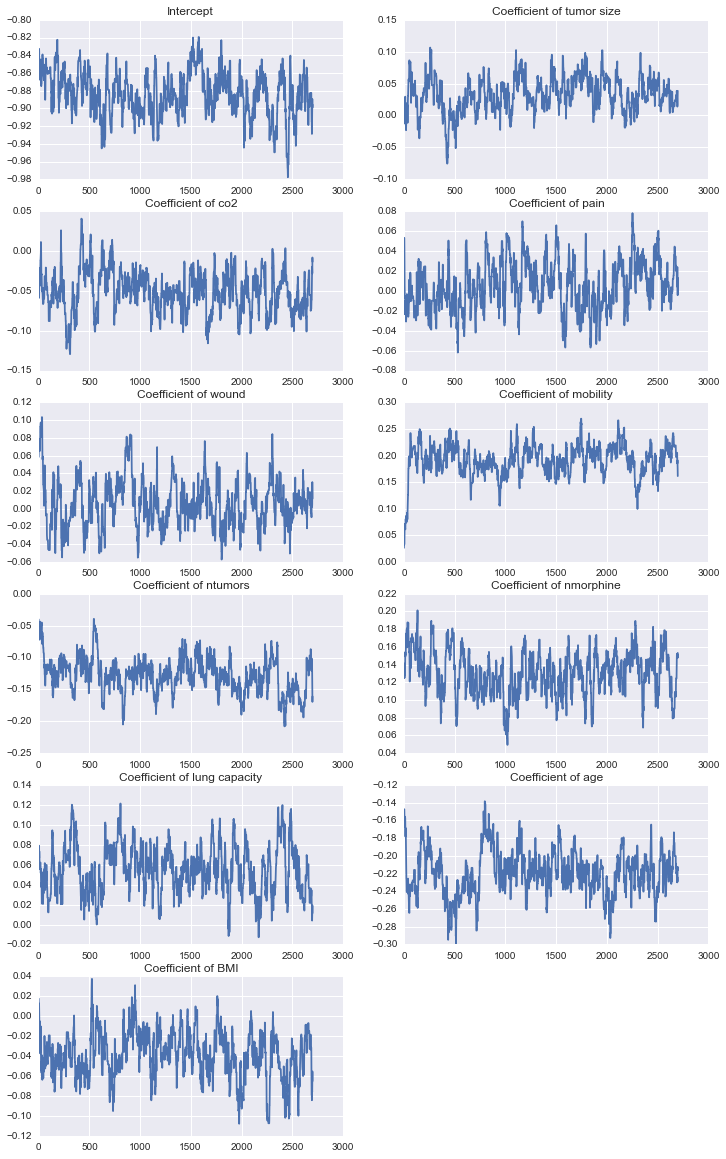

In [23]:
# Let us inspect the coefficients now
print coeffs.shape
print coeffs[coeffs.shape[0]-1,]
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
axarr[0,0].plot(range(0,coeffs.shape[0]),coeffs[:,0])
axarr[0,0].set_title('Intercept')
axarr[0,1].plot(range(0,coeffs.shape[0]),coeffs[:,1])
axarr[0,1].set_title('Coefficient of tumor size')
axarr[1,0].plot(range(0,coeffs.shape[0]),coeffs[:,2])
axarr[1,0].set_title('Coefficient of co2')
axarr[1,1].plot(range(0,coeffs.shape[0]),coeffs[:,3])
axarr[1,1].set_title('Coefficient of pain')
axarr[2,0].plot(range(0,coeffs.shape[0]),coeffs[:,4])
axarr[2,0].set_title('Coefficient of wound')
axarr[2,1].plot(range(0,coeffs.shape[0]),coeffs[:,5])
axarr[2,1].set_title('Coefficient of mobility')
axarr[3,0].plot(range(0,coeffs.shape[0]),coeffs[:,6])
axarr[3,0].set_title('Coefficient of ntumors')
axarr[3,1].plot(range(0,coeffs.shape[0]),coeffs[:,7])
axarr[3,1].set_title('Coefficient of nmorphine')
axarr[4,0].plot(range(0,coeffs.shape[0]),coeffs[:,8])
axarr[4,0].set_title('Coefficient of lung capacity')
axarr[4,1].plot(range(0,coeffs.shape[0]),coeffs[:,9])
axarr[4,1].set_title('Coefficient of age')
axarr[5,0].plot(range(0,coeffs.shape[0]),coeffs[:,10])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

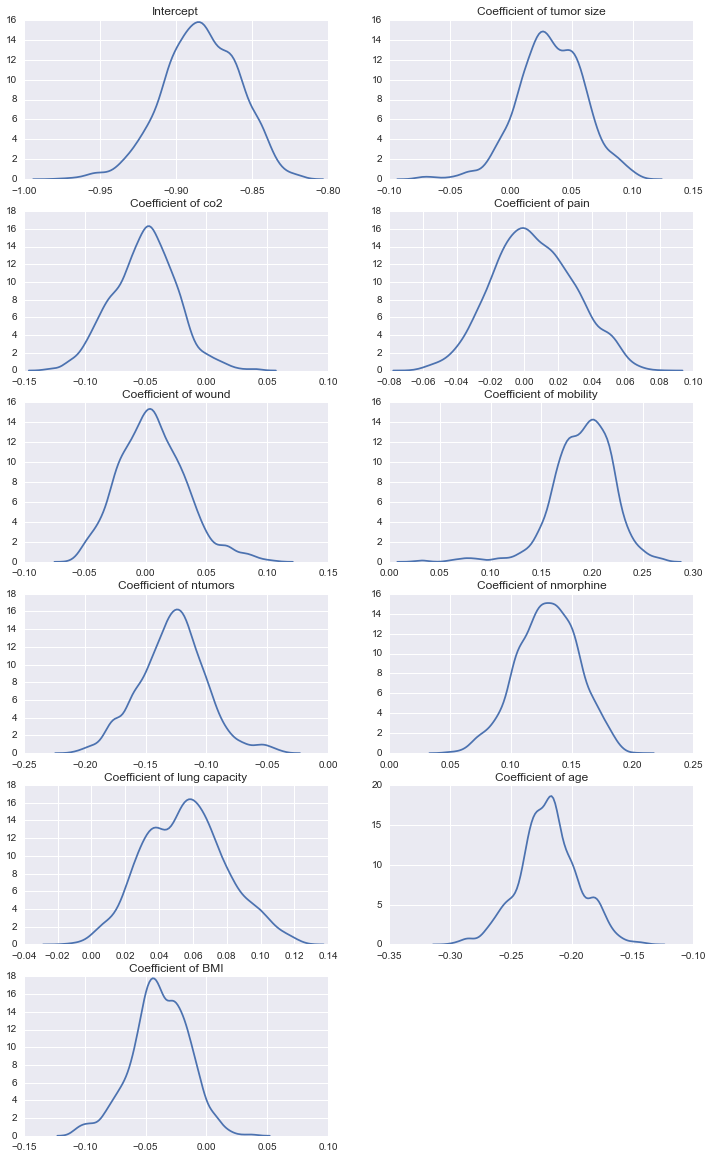

In [24]:
# Let us inspect the coefficients now
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
sns.kdeplot(coeffs[:,0], ax=axarr[0,0])
axarr[0,0].set_title('Intercept')
sns.kdeplot(coeffs[:,1],ax=axarr[0,1])
axarr[0,1].set_title('Coefficient of tumor size')
sns.kdeplot(coeffs[:,2], ax=axarr[1,0])
axarr[1,0].set_title('Coefficient of co2')
sns.kdeplot(coeffs[:,3],ax=axarr[1,1])
axarr[1,1].set_title('Coefficient of pain')
sns.kdeplot(coeffs[:,4],ax=axarr[2,0])
axarr[2,0].set_title('Coefficient of wound')
sns.kdeplot(coeffs[:,5],ax=axarr[2,1])
axarr[2,1].set_title('Coefficient of mobility')
sns.kdeplot(coeffs[:,6],ax=axarr[3,0])
axarr[3,0].set_title('Coefficient of ntumors')
sns.kdeplot(coeffs[:,7],ax=axarr[3,1])
axarr[3,1].set_title('Coefficient of nmorphine')
sns.kdeplot(coeffs[:,8],ax=axarr[4,0])
axarr[4,0].set_title('Coefficient of lung capacity')
sns.kdeplot(coeffs[:,9],ax=axarr[4,1])
axarr[4,1].set_title('Coefficient of age')
sns.kdeplot(coeffs[:,10],ax=axarr[5,0])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

In [25]:
#What are the mean and median coeffs
beta_mean = np.mean(coeffs,axis=0)
beta_median = np.median(coeffs,axis=0)
print beta_mean
print beta_median

[-0.88348612  0.03310132 -0.05092779  0.00558677  0.00586793  0.19095342
 -0.12768913  0.1303233   0.05544569 -0.21873176 -0.03837994]
[-0.88303534  0.0323306  -0.04956311  0.00370314  0.00426352  0.1935765
 -0.1271304   0.13068029  0.0554062  -0.21887058 -0.03844531]
